# Generating and Loading Parity-Check Matrices in the .alist file format
This code is provided as supplementary material of the lecture Channel Coding - Graph Based Codes (CC-GBC)

This code illustrates

* Generating LDPC codes according to Gallager's construction
* Storing the parity-check matrix in the .alist file format (see https://rptu.de/channel-codes/matrix-file-formats for a description)
* Loading and comparing the parity-check matrices

In [9]:
import numpy as np
from scipy.sparse import coo_matrix, vstack, issparse

Code to read the alist file format. The alist file format is a text file that contains a description of the matrix in the following format:
- The first line contains dimensions of the matrix as two integers: $m$ $n$
- the second line contains the largest column and row weights (degrees) as integers: $d_{\mathrm{v},\max}$, $d_{\mathrm{c},\max}$
- the third line contains $n$ integers with the individual column weights (variable node degrees)
- the fourth line contains $m$ integers with the individual row weights (check node degrees)
- The next $n$ lines describe for each column (variable node) the position of the "1" entries (connected check nodes). Each line contains exactly $d_{\mathrm{v},\max}$, if there are less than $d_{\mathrm{v},\max}$ connections, "0" is used to denote
unused entries
- The next $m$ lines describe for each row (check node) the position of the "1" entries (connected variable nodes). “0” is used to denote unused entries

Note that counting starts with "1" in contrast to python, where counting starts with "0".

In [10]:
def read_alist_file(filename):
    """
    Read an alist file and return the parity-check matrix H
    as a SciPy sparse matrix (COO format).
    """

    with open(filename, 'r') as f:
        # First line: N, M
        N, M = map(int, f.readline().split())

        # Second line: max_sum_dv, max_sum_dc
        max_sum_dv, max_sum_dc = map(int, f.readline().split())

        # Variable-node degrees (length N)
        sum_dv = list(map(int, f.readline().split()))

        # Check-node degrees (length M)
        sum_dc = list(map(int, f.readline().split()))

        # Read variable-node adjacency lists
        data = []
        for _ in range(N):
            row = list(map(int, f.readline().split()))
            data.append(row)

    # Convert to NumPy array: shape (N, max_sum_dv)
    row_idx = np.array(data)

    # MATLAB is 1-based; convert to 0-based indexing
    row_idx = row_idx - 1

    # Column indices: repeated variable indices
    col_idx = np.repeat(np.arange(N), max_sum_dv)

    # Flatten row indices row-wise
    row_idx = row_idx.flatten()

    # Keep only valid entries (row_idx >= 0)
    mask = row_idx >= 0
    row_idx = row_idx[mask]
    col_idx = col_idx[mask]

    # Values are all ones
    values = np.ones(len(row_idx), dtype=int)

    # Build sparse matrix (M x N)
    H = coo_matrix((values, (row_idx, col_idx)), shape=(M, N))

    return H


Code to write an alist file

In [11]:
def write_alist_file(H, filename, overwrite=False):
    """
    Write a parity-check matrix H (M x N) to an alist file.

    H: SciPy sparse matrix recommended (CSR/CSC/COO all ok)
    """
    import os

    if os.path.exists(filename) and not overwrite:
        print(f"Warning file: {filename} exists! Not overwriting.")
        return

    if not issparse(H):
        # Allow dense input too, but convert
        H = csr_matrix(H)

    M, N = H.shape

    # Use CSC for column adjacency, CSR for row adjacency
    Hc = H.tocsc()
    Hr = H.tocsr()

    # Degrees
    sum_dv = np.diff(Hc.indptr).astype(int)  # length N
    sum_dc = np.diff(Hr.indptr).astype(int)  # length M

    max_sum_dv = int(sum_dv.max()) if N > 0 else 0
    max_sum_dc = int(sum_dc.max()) if M > 0 else 0

    # --- Write header ---
    with open(filename, "w") as f:
        f.write(f"{N} {M}\n")
        f.write(f"{max_sum_dv} {max_sum_dc}\n")
        f.write(" ".join(map(str, sum_dv.tolist())) + "\n")
        f.write(" ".join(map(str, sum_dc.tolist())) + "\n")

        # --- Variable-node adjacency lists (N lines, each max_sum_dv ints) ---
        # Each line lists check-node indices (rows) connected to that variable (column), 1-based, padded with 0.
        for j in range(N):
            rows = Hc.indices[Hc.indptr[j]:Hc.indptr[j+1]]
            rows = np.sort(rows) + 1  # 1-based; sort for canonical output
            if max_sum_dv > 0:
                out = np.zeros(max_sum_dv, dtype=int)
                out[:rows.size] = rows
                f.write(" ".join(map(str, out.tolist())) + "\n")
            else:
                f.write("\n")

        # --- Check-node adjacency lists (M lines, each max_sum_dc ints) ---
        # Each line lists variable-node indices (cols) connected to that check (row), 1-based, padded with 0.
        for i in range(M):
            cols = Hr.indices[Hr.indptr[i]:Hr.indptr[i+1]]
            cols = np.sort(cols) + 1  # 1-based; sort for canonical output
            if max_sum_dc > 0:
                out = np.zeros(max_sum_dc, dtype=int)
                out[:cols.size] = cols
                f.write(" ".join(map(str, out.tolist())) + "\n")
            else:
                f.write("\n")


Generate a parity-check matrix according to Gallager's construction

In [12]:
# generate a parity-check matrix according to Gallager's method
# do not care about 4-cycles
def generate_Gallager(dv, dc, n):
    assert n % dc == 0, "n must be a multiple of check node degree dc"

    rows = n // dc
    # column indices
    jj = np.arange(n)
    ii = np.repeat(np.arange(rows), dc)
    Ho = coo_matrix((np.ones_like(jj), (ii, jj)), shape=(rows,n)).tocsr()
    H = Ho.copy()
    for _ in range(dv-1):
        H = vstack([H, Ho[:, np.random.permutation(n)]])
    
    return H

Test by generating a Gallager LDPC code, writing the matrix to a file and then reading the code again

In [37]:
H = generate_Gallager(dv=3, dc=6, n=60)
write_alist_file(H, "test_Gallager_n60_dv3_dc6.alist", overwrite=True)

H2 = read_alist_file("test_Gallager_n60_dv3_dc6.alist")
if (H.tocsr() != H2.tocsr()).nnz == 0:
    print("Both matrices are identical!")
else:   
    print("ERROR: matrices not identical!")

Both matrices are identical!


Plot the parity-check matrix:

(30.0, -0.5)

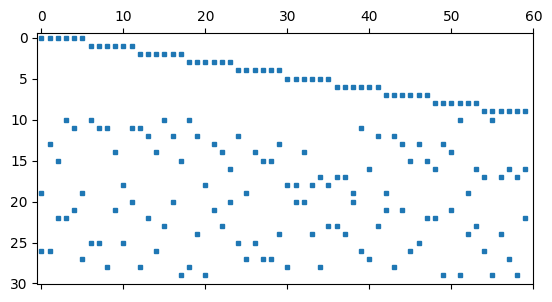

In [49]:
import matplotlib.pyplot as plt 
plt.spy(H,markersize=3)
plt.xlim((-0.5,60))
plt.ylim((30,-0.5))